In [2]:
#Data Protection Challenges in Information Security and application of AI in mitigating the issue using machine learning
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import warnings  # Warnings module is used to manage warnings in the code
warnings.filterwarnings("ignore")  # This line suppresses warnings to avoid clutter in the output
df = pd.read_csv('/content/breach_report.csv')
df

,index,Name of Covered Entity,State,Covered Entity Type,Individuals Affected,Breach Submission Date,Type of Breach,Location of Breached Information,Business Associate Present,Web Description
0,0,Brooke Army Medical Center,TX,Healthcare Provider,1000.0,10/21/09,Theft,Paper/Films,No,A binder containing the protected health infor...
1,1,"Mid America Kidney Stone Association, LLC",MO,Healthcare Provider,1000.0,10/28/09,Theft,Network Server,No,Five desktop computers containing unencrypted ...
2,2,Alaska Department of Health and Social Services,AK,Healthcare Provider,501.0,10/30/09,Theft,"Other, Other Portable Electronic Device",No,\N
3,3,Health Services for Children with Special Need...,DC,Health Plan,3800.0,11/17/09,Loss,Laptop,No,A laptop was lost by an employee while in tran...
4,4,"Mark D. Lurie, MD",CA,Healthcare Provider,5166.0,11/20/09,Theft,Desktop Computer,No,A shared Computer that was used for backup was...
...,...,...,...,...,...,...,...,...,...,...
9995,71,TOWERS WATSON,VA,Business Associate,1874.0,4/27/10,Theft,Other,Yes,"A business associate (BA), Towers Watson, of t..."
9996,72,South Texas Veterans Health Care System,TX,Healthcare Provider,1430.0,4/28/10,"Improper Disposal, Loss",Paper/Films,No,\N
9997,73,Rockbridge Area Community Services,VA,Healthcare Provider,500.0,4/29/10,Theft,"Desktop Computer, Laptop",No,\N
9998,74,"Millennium Medical Management Resources, Inc.",IL,Business Associate,180111.0,4/29/10,Theft,"Other, Other Portable Electronic Device",Yes,\N


In [ ]:
df['Type of Breach'].value_counts()

In [ ]:
# Basic information about dataset
print("\nDataset Info:")
df.info()
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())
# Replace placeholder '\N' with actual NaN values
df.replace('\\N', np.nan, inplace=True)
# Convert 'Breach Submission Date' to datetime format
df['Breach Submission Date'] = pd.to_datetime(df['Breach Submission Date'], errors='coerce')
# Convert 'Individuals Affected' to numeric
df['Individuals Affected'] = pd.to_numeric(df['Individuals Affected'], errors='coerce')
# Summary statistics
print("\nSummary statistics for numeric columns:")
print(df.describe())

In [ ]:
# Check number of unique values in categorical columns
print("\nUnique values in categorical columns:")
categorical_columns = df.select_dtypes(include='object').columns
for col in categorical_columns:
    print(f"{col}: {df[col].nunique()}")


In [ ]:
# Top 5 states with most breaches
print("\nTop 5 states with most breaches:")
print(df['State'].value_counts().head())
# Top 5 types of breaches
print("\nMost common breach types:")
print(df['Type of Breach'].value_counts().head())

In [7]:
# Replace placeholder '\N' with NaN
df.replace('\\N', np.nan, inplace=True)

# Convert date and numeric columns
df['Breach Submission Date'] = pd.to_datetime(df['Breach Submission Date'], errors='coerce')
df['Individuals Affected'] = pd.to_numeric(df['Individuals Affected'], errors='coerce')

# ----------- Missing Value Handling -----------

# 1. 'State': fill with 'Unknown' as it is a location-based identifier
df['State'].fillna('Unknown', inplace=True)

# 2. 'Covered Entity Type': fill missing values with mode (most common type)
df['Covered Entity Type'].fillna(df['Covered Entity Type'].mode()[0], inplace=True)

# 3. 'Individuals Affected': fill with median (robust to outliers)
df['Individuals Affected'].fillna(df['Individuals Affected'].median(), inplace=True)

# 4. 'Type of Breach': fill with 'Unknown'
df['Type of Breach'].fillna('Unknown', inplace=True)

# 5. 'Location of Breached Info': fill with 'Unknown'
df['Location of Breached Information'].fillna('Unknown', inplace=True)

# 6. 'Web Description': drop column due to large number of missing values (not suitable for numeric analysis)
df.drop(columns=['Web Description'], inplace=True)

# New Section

In [ ]:
# ----------- Graphs and Analysis -----------
plt.figure(figsize=(8,6))
# 1. Bar Chart - Top 10 Breach Types
sns.countplot(data=df, x='Type of Breach', order=df['Type of Breach'].value_counts().head(10).index)
plt.title("Top 10 Types of Data Breaches")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# 2. Pie Chart - Covered Entity Types
plt.figure(figsize=(6, 6))
df['Covered Entity Type'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title("Distribution of Covered Entity Types")
plt.ylabel("")
plt.show()

In [ ]:
# 3. Histogram - Distribution of Individuals Affected
plt.figure(figsize=(8, 5))
sns.histplot(df['Individuals Affected'], bins=30, kde=True, color='orange')
plt.title("Histogram: Individuals Affected by Breach")
plt.xlabel("Individuals Affected")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [ ]:
# 4. Bar Chart - Top 10 States with Breaches
plt.figure(figsize=(8,5))
df['State'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 States by Number of Breaches")
plt.xlabel("State")
plt.ylabel("Number of Breaches")
plt.tight_layout()
plt.show()

In [ ]:
# 6. Scatter Plot - Submission Date vs. Individuals Affected
plt.figure(figsize=(8,4))
sns.scatterplot(x='Breach Submission Date', y='Individuals Affected', data=df, alpha=0.5)
plt.title("Individuals Affected Over Time")
plt.xlabel("Breach Submission Date")
plt.ylabel("Individuals Affected")
plt.tight_layout()
plt.show()

In [ ]:
# 5. Heatmap - Correlation Matrix (only numeric columns)
plt.figure(figsize=(6, 4))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [ ]:
# Bar Chart - Business Associate involvement
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Business Associate Present', palette='Set2')
plt.title("Breaches Involving Business Associates")
plt.tight_layout()
plt.show()

In [ ]:
# Pie Chart - Location of Breach (Top 5)
top_locations = df['Location of Breached Information'].value_counts().head(5)
plt.figure(figsize=(6, 6))
top_locations.plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set3'))
plt.title("Top 5 Locations of Breached Information")
plt.ylabel("")
plt.show()

In [ ]:
# Bar Chart - Top 5 Covered Entities with Most Affected Individuals (Summed)
top_entities = df.groupby('Covered Entity Type')['Individuals Affected'].sum().sort_values(ascending=False).head()
plt.figure(figsize=(8, 5))
top_entities.plot(kind='bar', color='purple')
plt.title("Top Entity Types by Total Individuals Affected")
plt.ylabel("Total Individuals Affected")
plt.xlabel("Covered Entity Type")
plt.tight_layout()
plt.show()

In [17]:
df = df.drop(columns=['Breach Submission Date'])

In [ ]:
# Top 5 breach types
top_5_types = df['Type of Breach'].value_counts().nlargest(5).index.tolist()

# Replace all other types with 'Other'
df['Type of Breach'] = df['Type of Breach'].apply(lambda x: x if x in top_5_types else 'Other')
# ----------------- Label Encoding Categorical Columns -----------------
# Identify categorical columns
categorical_cols = df.select_dtypes(include="object").columns

# Apply label encoding to each categorical column
le_dict = {}  # Save label encoders in case we need them later (e.g., for inverse transform)
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # Store encoder for future use

# Show label mapping for 'Type of Breach'
type_of_breach_le = le_dict['Type of Breach']
print("\nLabel mapping for 'Type of Breach':")
for i, label in enumerate(type_of_breach_le.classes_):
    print(f"{i}: {label}")

In [19]:
# Scale 'Individuals Affected' using StandardScaler
scaler = StandardScaler()
df["Individuals Affected"] = scaler.fit_transform(df[["Individuals Affected"]])


In [20]:
# -------------------- Train-Test Split --------------------
target = "Type of Breach"
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [21]:
# -------------------- Apply SMOTE Safely --------------------
# Check class distribution
class_counts = Counter(y_train)
min_class_samples = min(class_counts.values())

# Set k_neighbors safely
k_neighbors = min(min_class_samples - 1, 5)
sm = SMOTE(random_state=42, k_neighbors=k_neighbors)

X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

In [ ]:
# -------------------- Output Class Distributions --------------------
print("Original class distribution (before SMOTE):")
print(pd.Series(y_train).value_counts())

print("\nBalanced class distribution (after SMOTE):")
print(pd.Series(y_train_bal).value_counts())


Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       261
           1       1.00      1.00      1.00       139
           2       1.00      1.00      1.00       277
           3       1.00      1.00      1.00       860
           4       1.00      1.00      1.00       463

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Kappa Score: 1.0

👥 K-Nearest Neighbors

Best Params: {'n_neighbors': 3, 'weights': 'distance'}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       261
           1       1.00      1.00      1.00       139
           2       1.00      1.00      1.00       277
           3       1.00      1.00      1.00       860
           4       

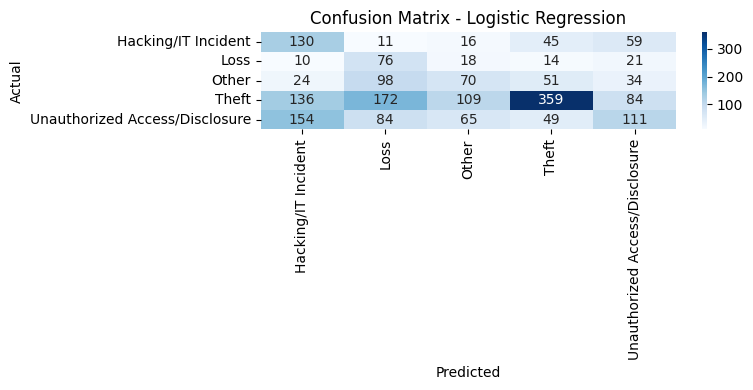

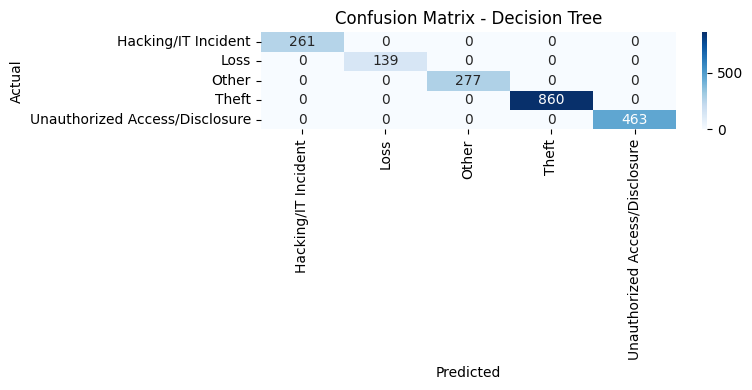

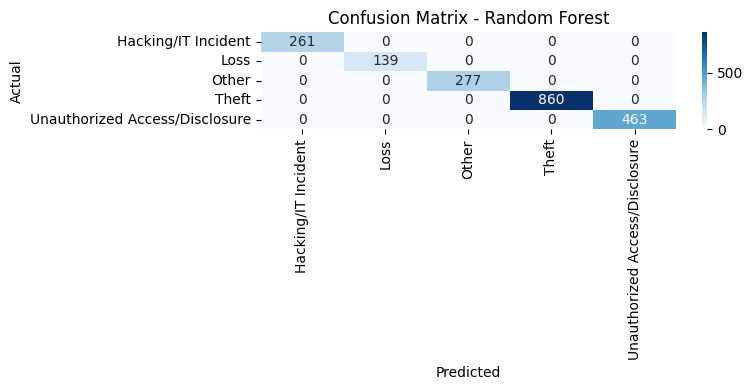

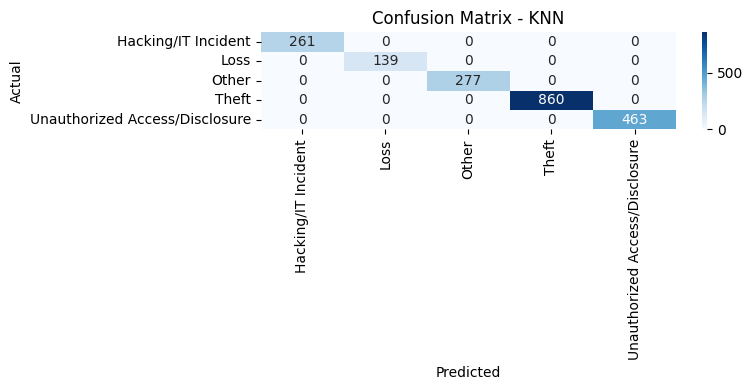

In [23]:
# Dictionary to store the best models
best_models = {}

# Dictionary to store classification reports
model_reports = {}

# -------------------- 1. Logistic Regression --------------------
print("🔍 Logistic Regression")

# Define hyperparameters to tune
lr_params = {
    'C': [0.01, 0.1, 1, 10],              # Regularization strength
    'penalty': ['l2'],                    # Type of penalty
    'solver': ['lbfgs', 'liblinear']      # Solvers compatible with l2
}

# Initialize the model
lr = LogisticRegression(max_iter=1000)

# GridSearchCV for hyperparameter tuning
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='f1_weighted', n_jobs=-1)
lr_grid.fit(X_train_bal, y_train_bal)  # Train the model on balanced training data

# Save the best model
best_models['Logistic Regression'] = lr_grid.best_estimator_

# Predict on test set
y_pred_lr = lr_grid.predict(X_test)

# Print best parameters and evaluation metrics
print("\nBest Params:", lr_grid.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Kappa Score:", cohen_kappa_score(y_test, y_pred_lr))

# Save classification report
model_reports['Logistic Regression'] = classification_report(y_test, y_pred_lr, output_dict=True)

# -------------------- 2. Decision Tree --------------------
print("\n🌳 Decision Tree")

# Define hyperparameter grid
dt_params = {
    'max_depth': [5, 10, 20, None],           # Tree depth
    'min_samples_split': [2, 5, 10]           # Minimum samples to split a node
}

# Initialize model
dt = DecisionTreeClassifier(random_state=42)

# Grid search
dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='f1_weighted', n_jobs=-1)
dt_grid.fit(X_train_bal, y_train_bal)

# Save best model
best_models['Decision Tree'] = dt_grid.best_estimator_

# Predict and evaluate
y_pred_dt = dt_grid.predict(X_test)

print("\nBest Params:", dt_grid.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Kappa Score:", cohen_kappa_score(y_test, y_pred_dt))

model_reports['Decision Tree'] = classification_report(y_test, y_pred_dt, output_dict=True)

# -------------------- 3. Random Forest --------------------
print("\n🌲 Random Forest")

# Hyperparameter grid
rf_params = {
    'n_estimators': [50, 100, 200],            # Number of trees
    'max_depth': [10, 20, None],               # Max depth
    'min_samples_split': [2, 5]                # Node split control
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Grid search
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='f1_weighted', n_jobs=-1)
rf_grid.fit(X_train_bal, y_train_bal)

# Save best model
best_models['Random Forest'] = rf_grid.best_estimator_

# Predict and evaluate
y_pred_rf = rf_grid.predict(X_test)

print("\nBest Params:", rf_grid.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Kappa Score:", cohen_kappa_score(y_test, y_pred_rf))

model_reports['Random Forest'] = classification_report(y_test, y_pred_rf, output_dict=True)

# -------------------- 4. K-Nearest Neighbors --------------------
print("\n👥 K-Nearest Neighbors")

# Hyperparameter grid
knn_params = {
    'n_neighbors': [3, 5, 7],           # Number of neighbors
    'weights': ['uniform', 'distance']  # Weighting method
}

# Initialize model
knn = KNeighborsClassifier()

# Grid search
knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='f1_weighted', n_jobs=-1)
knn_grid.fit(X_train_bal, y_train_bal)

# Save best model
best_models['KNN'] = knn_grid.best_estimator_

# Predict and evaluate
y_pred_knn = knn_grid.predict(X_test)

print("\nBest Params:", knn_grid.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_knn))
print("Kappa Score:", cohen_kappa_score(y_test, y_pred_knn))

model_reports['KNN'] = classification_report(y_test, y_pred_knn, output_dict=True)

# -------------------- Compare Confusion Matrices --------------------
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=type_of_breach_le.classes_, yticklabels=type_of_breach_le.classes_)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")
plot_confusion_matrix(y_test, y_pred_dt, "Decision Tree")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_confusion_matrix(y_test, y_pred_knn, "KNN")

In [24]:
import joblib
import os

# Create a directory to save models if it doesn't exist
os.makedirs("saved_models", exist_ok=True)

# Loop through the best models dictionary and save each model
for name, model in best_models.items():
    filename = f"saved_models/{name.replace(' ', '_').lower()}_model.pkl"
    joblib.dump(model, filename)
    print(f"✅ Saved: {filename}")

✅ Saved: saved_models/logistic_regression_model.pkl
✅ Saved: saved_models/decision_tree_model.pkl
✅ Saved: saved_models/random_forest_model.pkl
✅ Saved: saved_models/knn_model.pkl
